In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from generate_data import generate_multi_sim_and_obs

from sepia.SepiaModel import SepiaModel
from sepia.SepiaData import SepiaData
import sepia.SepiaPlot as SepiaPlot
%load_ext autoreload
%autoreload 2

## Multivariate-output simple example

First, we generate the synthetic data.

In [2]:
seed = 42   # random seed
m = 100     # number of simulated observations
n = 1       # number of observed data
sig_n = 0.01 # observation noise SD

data_dict = generate_multi_sim_and_obs(m=m, n=n, sig_n=sig_n, seed=seed)


Next, we initialize the SepiaData object which does some basic checking about whether the input data
are of the correct shapes, and infers what kind of model you're going to use based on the input data.

This SepiaData instance implies the following:
This is a simulator and obs model, sim y dimension 50, obs y dimension 20
n  =     1 (number of observed data)
m  =   100 (number of simulated data)
p  =     1 (number of inputs)
q  =     3 (number of additional simulation inputs to calibrate)
pu NOT SET (transformed response dimension); call method create_K_basis
pv NOT SET (transformed discrepancy dimension); call method create_D_basis



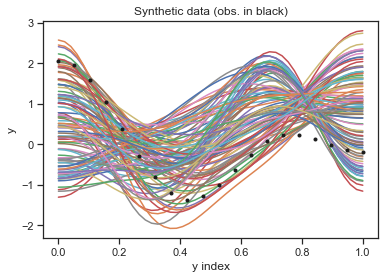

In [3]:
data = SepiaData(t_sim=data_dict['t_sim'], y_sim=data_dict['y_sim'], y_ind_sim=data_dict['y_ind_sim'],
                 y_obs=data_dict['y_obs'], y_ind_obs=data_dict['y_ind_obs'])

print(data)

plt.plot(data.sim_data.y_ind, data.sim_data.y.T)
plt.plot(data.obs_data.y_ind, data.obs_data.y.T, 'k.', linewidth=3)
plt.title('Synthetic data (obs. in black)')
plt.xlabel('y index')
plt.ylabel('y')
plt.show()

Standardization of data is important for default priors in the model to work well.

We also create a PCA basis with 5 components to represent the multivariate output.

In [4]:
data.transform_xt()
data.standardize_y(scale='columnwise')
data.create_K_basis(5)
data.create_D_basis(type='linear')

print(data)

This SepiaData instance implies the following:
This is a simulator and obs model, sim y dimension 50, obs y dimension 20
n  =     1 (number of observed data)
m  =   100 (number of simulated data)
p  =     1 (number of inputs)
q  =     3 (number of additional simulation inputs to calibrate)
pu =     5 (transformed response dimension)
pv =     2 (transformed discrepancy dimension)



Next, we set up the model object; a lot of precalculation of important model components is done here.

In [5]:
model = SepiaModel(data)

lamWOs initialized outside default bounds [60, 1e5]; setting initial value to 1e5 - 1.


In [6]:
model.verbose=False
opt_prm = model.optim_logPost(maxiter=10000,xatol=100,fatol=100)

optimizing logpost over all parameters
Optimization terminated successfully.
         Current function value: -17192.474939
         Iterations: 5075
         Function evaluations: 7819
  param    init value     opt value
  theta      0.500000      0.912631
  theta      0.500000      0.000016
  theta      0.500000      0.999987
  betaV      0.100000      0.094418
  betaU      0.100000      0.108633
  betaU      0.100000      0.078349
  betaU      0.100000      0.099266
  betaU      0.100000      0.101845
  betaU      0.100000      0.108116
  betaU      0.100000      0.094834
  betaU      0.100000      0.107411
  betaU      0.100000      0.089809
  betaU      0.100000      0.124292
  betaU      0.100000      0.126714
  betaU      0.100000      0.101082
  betaU      0.100000      0.110209
  betaU      0.100000      0.122350
  betaU      0.100000      0.068947
  betaU      0.100000      0.091611
  betaU      0.100000      0.100363
  betaU      0.100000      0.090140
  betaU      0.100000 

We will use all the default priors and settings to do MCMC.

We first call `model.tune_step_sizes(50, 20)` which uses 50 samples over 20 different step sizes
to estimate the mcmc step sizes for the best acceptance rate.

We then draw 1000 MCMC samples.

In [7]:
cachefile_name='multivariate_example_with_prediction.pkl'
import os.path
import pickle
if os.path.isfile(cachefile_name):
    model=pickle.load(open(cachefile_name, "rb" ))
else:
    model.tune_step_sizes(50, 20, update_vals=False)
    model.do_mcmc(5000)
    pickle.dump(model, open( cachefile_name, "w+b" ))


Step size tuning:   0%|          | 0/50 [00:00<?, ?it/s]

Starting tune_step_sizes...
Default step sizes:
theta
[[0.2 0.2 0.2]]
betaV
[[0.1]]
betaU
[[0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1]]
lamVz
[[10.]]
lamUz
[[5. 5. 5. 5. 5.]]
lamWs
[[100. 100. 100. 100. 100.]]
lamWOs
[[100.]]
lamOs
[[1278.1561292]]


MCMC sampling:   0%|          | 0/5000 [00:00<?, ?it/s]

Done with tune_step_size.
Selected step sizes:
theta
[[0.33054089 0.17487566 0.23955033]]
betaV
[[0.25911274]]
betaU
[[0.19729415 0.5664121  0.67201248 0.52609382 0.91803415]
 [0.07308489 0.13259468 0.19771694 0.11490279 0.25444997]
 [0.14079273 0.16274527 0.14092346 0.33444757 0.18379535]
 [0.10208694 0.12079588 0.17957041 0.30742162 0.38054853]]
lamVz
[[2.37464779]]
lamUz
[[1.01378015 0.38037903 0.18605081 0.0933034  0.09514151]]
lamWs
[[16701.20006201 17132.35104084 11612.92584337 10751.17773697
   6592.33577688]]
lamWOs
[[282.63728035]]
lamOs
[[43.6708733]]


MCMC sampling: 100%|██████████| 5000/5000 [02:46<00:00, 30.06it/s]


Here is a basic visualization of the MCMC results: histograms of the MCMC samples.

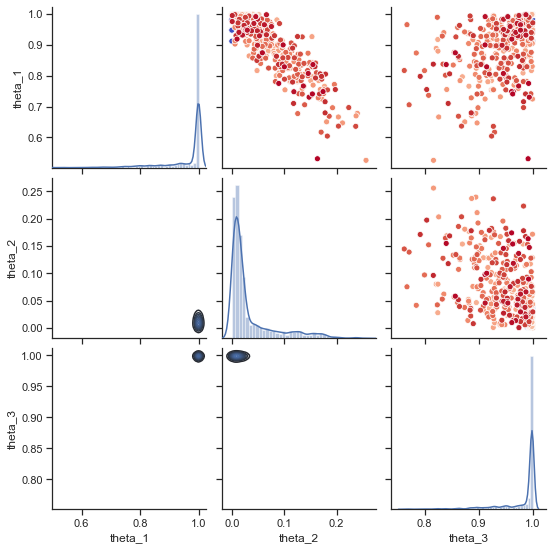

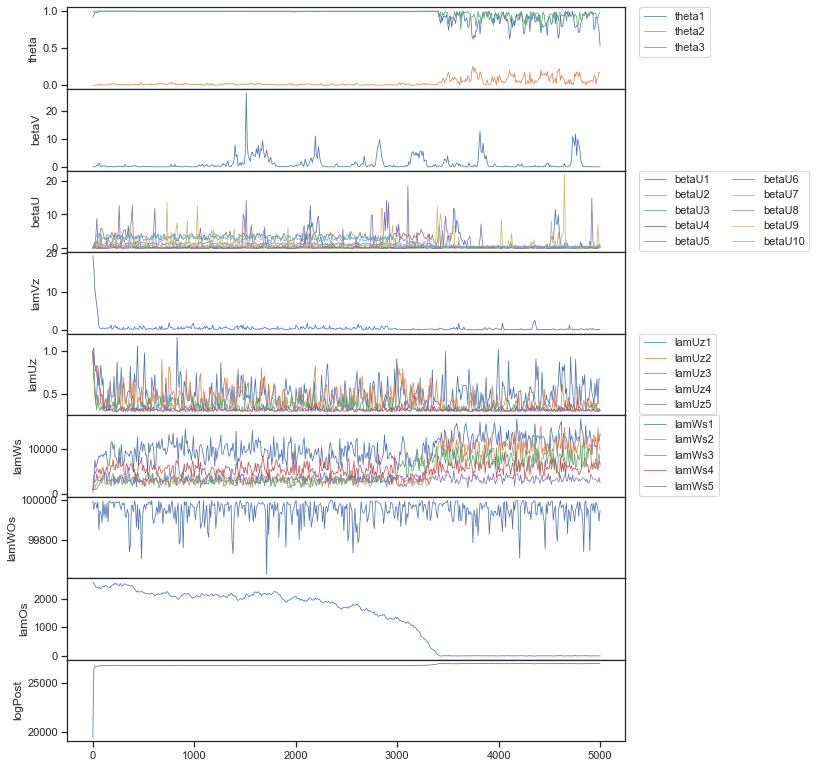

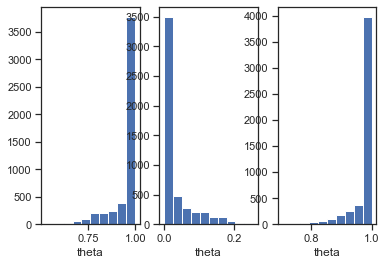

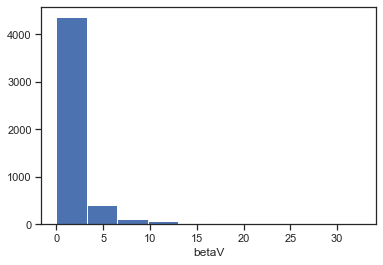

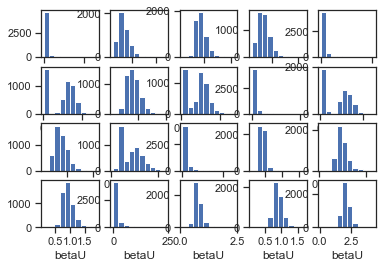

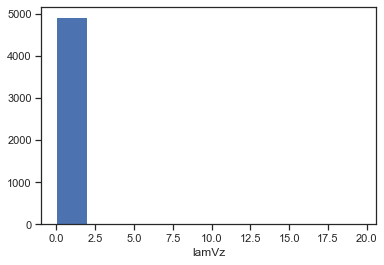

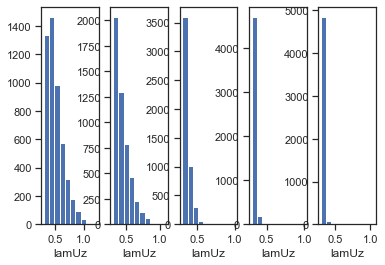

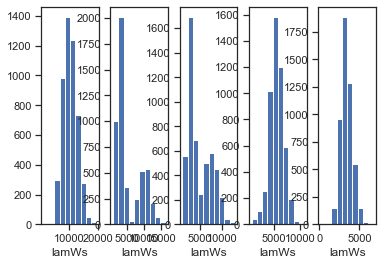

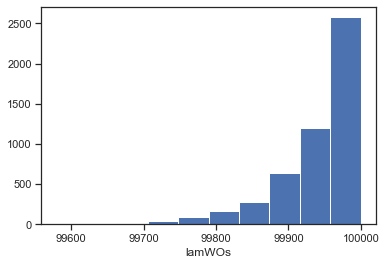

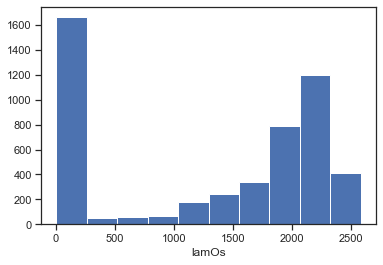

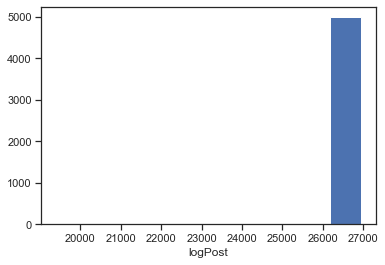

In [8]:
# Extract MCMC samples into dictionary with parameter names
#samples_dict = {p.name: p.mcmc_to_array() for p in model.params.mcmcList}
samples_dict = model.get_samples()
SepiaPlot.theta_pairs(samples_dict)
SepiaPlot.mcmc_trace(samples_dict)

for i, k in enumerate(samples_dict.keys()):
    param_shape = samples_dict[k].shape[1]
    if param_shape >= 5:
        ncol = 5
        nrow = int(np.ceil(param_shape / ncol))
    else:
        ncol = param_shape
        nrow = 1
    plt.figure(i)
    for j in range(param_shape):
        plt.subplot(nrow, ncol, j + 1)
        plt.hist(samples_dict[k][:, j])
        plt.xlabel(k)
    plt.show()

The parameters `betaU` and `lamUz` correspond to the Gaussian process lengthscale and marginal variance,
while `lamWs`, `lamWOs`, and `lamOs` are nugget and observation noise precisions.

Most easy to interpret is `theta`, which is the posterior distribution over the $t$ that generated $y_{obs}$.

----
## Predictions of model output from the full model

First, predictions showing just the emulator response, using
SepiaEmulatorPredict

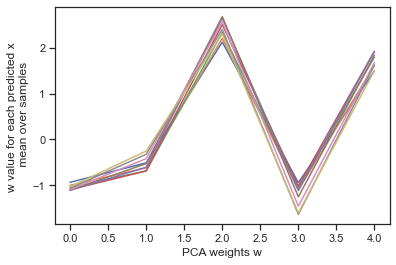

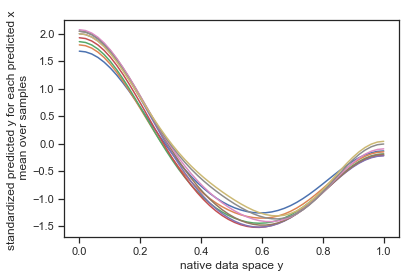

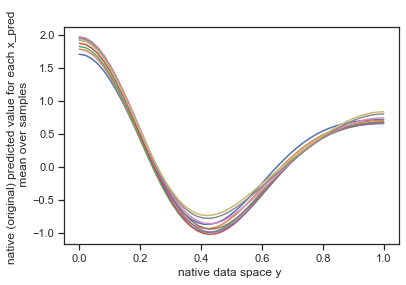

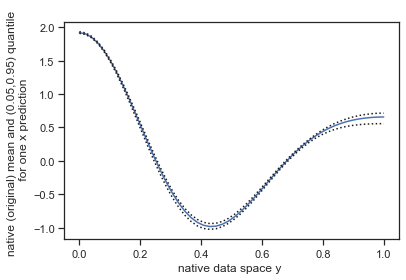

In [9]:
model.verbose=True

from sepia.SepiaPredict import SepiaEmulatorPrediction
x_pred=np.linspace(0,1,9).reshape((9,1))
# make t_pred most like the calibrated thetas for comparison to below
t_pred=np.tile(np.array([1,0,1]).reshape(1,3),(9,1)) 
pred_samples=model.get_samples(numsamples=7)
pred=SepiaEmulatorPrediction(x_pred=x_pred, samples=pred_samples, model=model, t_pred=t_pred)

predw=pred.get_w()
plt.figure()
plt.plot(np.mean(predw,0).T)
plt.xlabel('PCA weights w')
plt.ylabel('w value for each predicted x \n mean over samples')
plt.show()

predystd=pred.get_y(std=True)
plt.figure()
plt.plot(model.data.sim_data.y_ind,np.mean(predystd,0).T)
plt.xlabel('native data space y')
plt.ylabel('standardized predicted y for each predicted x \n mean over samples')
plt.show()

predy=pred.get_y()
plt.figure()
plt.plot(model.data.sim_data.y_ind,np.mean(predy,0).T)
plt.xlabel('native data space y ')
plt.ylabel('native (original) predicted value for each x_pred \n mean over samples')
plt.show()

predy=pred.get_y()
plt.figure()
plt.plot(model.data.sim_data.y_ind,np.mean(predy[:,4,:],0).T)
plt.plot(model.data.sim_data.y_ind,np.quantile(predy[:,4,:],[0.05, 0.95],axis=0).T,'k:')
plt.xlabel('native data space y ')
plt.ylabel('native (original) mean and (0.05,0.95) quantile \n for one x prediction')
plt.show()


And below are similar predictions for the full models responses joint u and v


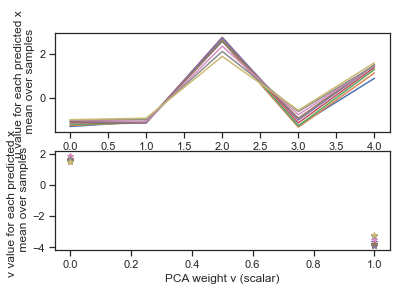

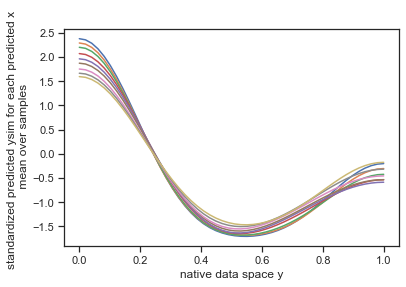

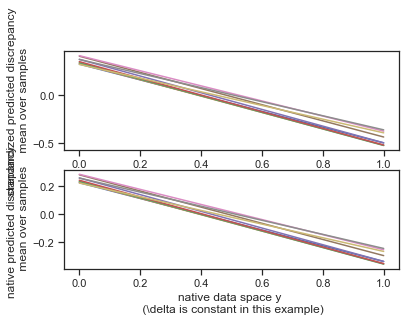

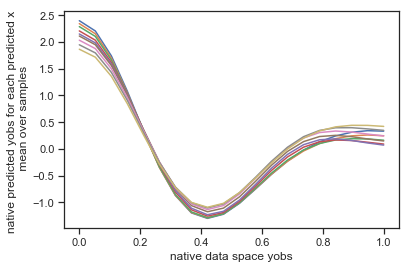

In [10]:
from sepia.SepiaPredict import SepiaFullPrediction
x_pred=np.linspace(0,1,9).reshape(9,1)
pred_samples=model.get_samples(numsamples=7)
pred=SepiaFullPrediction(x_pred, pred_samples, model)

plt.figure()
predu, predv = pred.get_u_v()
plt.subplot(2,1,1)
plt.plot(np.mean(predu,0).T)
plt.xlabel('PCA weights u')
plt.ylabel('u value for each predicted x \n mean over samples')
plt.subplot(2,1,2)
plt.plot(np.mean(predv,0).T,'*')
plt.xlabel('PCA weight v (scalar)')
plt.ylabel('v value for each predicted x \n mean over samples')
plt.show()

predysimstd=pred.get_ysim(std=True)
plt.figure()
plt.plot(model.data.sim_data.y_ind,np.mean(predysimstd,0).T)
plt.xlabel('native data space y')
plt.ylabel('standardized predicted ysim for each predicted x \n mean over samples')
plt.show()

preddstd=pred.get_discrepancy(as_obs=True,std=True)
predd=pred.get_discrepancy(as_obs=True)
plt.figure()
plt.subplot(2,1,1)
plt.plot(model.data.obs_data.y_ind,np.mean(preddstd,0).T)
plt.xlabel('native data space y \n (\delta is constant in this example)')
plt.ylabel('standardized predicted discrepancy\n mean over samples')
plt.subplot(2,1,2)
plt.plot(model.data.obs_data.y_ind,np.mean(predd,0).T)
plt.xlabel('native data space y \n (\delta is constant in this example)')
plt.ylabel('native predicted discrepancy \n mean over samples')
plt.show()

predyobs=pred.get_yobs(as_obs=True)
plt.figure()
plt.plot(model.data.obs_data.y_ind,np.mean(predyobs,0).T)
plt.xlabel('native data space yobs')
plt.ylabel('native predicted yobs for each predicted x \n mean over samples')
plt.show()

### Summary plot of predicted uncertainty for an observation.
The 5th prediction done corresponds to the observation in the model, with xpred=0.5.

/Users/granthutchings/opt/anaconda3/envs/sepia/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: The handle <matplotlib.lines.Line2D object at 0x1c2044b5f8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  # This is added back by InteractiveShellApp.init_path()


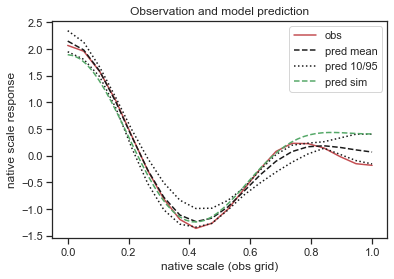

In [11]:
predyobs=pred.get_yobs(as_obs=True)
predysim=pred.get_ysim()
plt.figure()
plt.plot(model.data.obs_data.y_ind,model.data.obs_data.y.T,'r')
plt.plot(model.data.obs_data.y_ind,np.mean(predyobs[:,4,:],0).T,'k--')
plt.plot(model.data.obs_data.y_ind,np.quantile(predyobs[:,4,:],[0.05, 0.95],axis=0).T,'k:')
plt.plot(model.data.sim_data.y_ind,np.mean(predysim[:,4,:],0).T,'g--')
plt.xlabel('native scale (obs grid)')
plt.ylabel('native scale response')
plt.title('Observation and model prediction')
plt.legend(['obs','pred mean','pred 10/95', '_nolegend_', 'pred sim'])
plt.show()


---
## Predictions from an Emulator-only model.

The above showed that the emulator response alone can be predicted in
a full model. This section will show that that this also functions in an
emulator-only model (i.e., no observations or corresponding calibration).

This should be nearly identical to the emulator predictions above.

In [12]:
data2 = SepiaData(t_sim=data_dict['t_sim'], y_sim=data_dict['y_sim'], y_ind_sim=data_dict['y_ind_sim'])
data2.transform_xt()
data2.standardize_y()
data2.create_K_basis(5)

print(data2)

model2 = SepiaModel(data2)

This SepiaData instance implies the following:
This is a simulator (eta)-only model, y dimension 50
m  =   100 (number of simulated data)
p  =     1 (number of inputs)
q  =     3 (number of additional simulation inputs)
pu =     5 (transformed response dimension)

lamWOs initialized outside default bounds [60, 1e5]; setting initial value to 1e5 - 1.


We will use all the default priors and settings to do MCMC.

We first call `model.tune_step_sizes(10, 20)` which uses 50 samples over 20 different step sizes
to estimate the mcmc step sizes for the best acceptance rate.

We then draw MCMC samples.

In [13]:
model2.tune_step_sizes(10, 20)
model2.do_mcmc(100)

Step size tuning:   0%|          | 0/10 [00:00<?, ?it/s]

Starting tune_step_sizes...
Default step sizes:
betaU
[[0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1]]
lamUz
[[5. 5. 5. 5. 5.]]
lamWs
[[100. 100. 100. 100. 100.]]
lamWOs
[[100.]]


MCMC sampling:   0%|          | 0/100 [00:00<?, ?it/s]

Done with tune_step_size.
Selected step sizes:
betaU
[[1.39917162 0.40236939 0.6134622  0.40690613 0.67900205]
 [0.06720216 0.1272828  0.10760014 0.11324102 0.30640392]
 [0.20929225 0.11736148 0.10821088 0.54651906 0.16586473]
 [0.11062129 0.12201026 0.16566494 0.27597834 0.40861826]]
lamUz
[[1.13656379 0.40036222 0.31625404 0.12682479 0.12921005]]
lamWs
[[14256.90984951  9180.29767775 16815.74431773  8300.63598776
   6544.64696319]]
lamWOs
[[299.6270656]]


MCMC sampling: 100%|██████████| 100/100 [00:01<00:00, 74.54it/s]


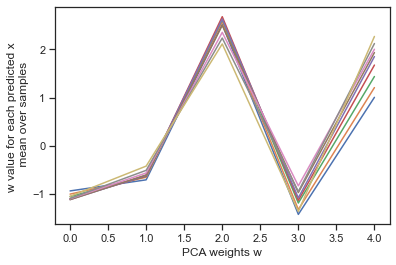

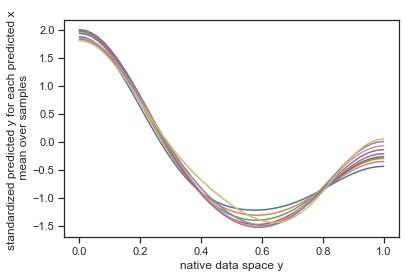

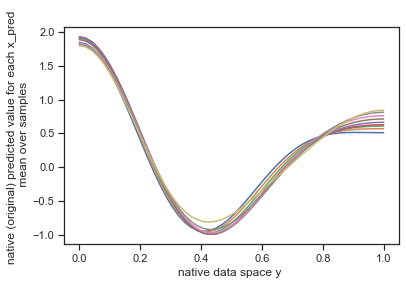

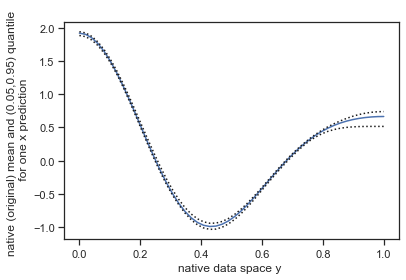

In [14]:
model2.verbose=True

from sepia.SepiaPredict import SepiaEmulatorPrediction
x_pred=np.linspace(0,1,9).reshape(9,1)
#t_pred=0.5*np.ones((9,3))
# make t_pred most like the calibrated thetas for comparison to below
t_pred=np.tile(np.array([1,0,1]).reshape(1,3),(9,1))
pred_samples=model.get_samples(numsamples=7)
pred2=SepiaEmulatorPrediction(x_pred=x_pred, samples=pred_samples, model=model2, t_pred=t_pred)

predw=pred2.get_w()
plt.figure()
plt.plot(np.mean(predw,0).T)
plt.xlabel('PCA weights w')
plt.ylabel('w value for each predicted x \n mean over samples')
plt.show()

predystd=pred2.get_y(std=True)
plt.figure()
plt.plot(model.data.sim_data.y_ind,np.mean(predystd,0).T)
plt.xlabel('native data space y')
plt.ylabel('standardized predicted y for each predicted x \n mean over samples')
plt.show()

predy=pred2.get_y()
plt.figure()
plt.plot(model.data.sim_data.y_ind,np.mean(predy,0).T)
plt.xlabel('native data space y ')
plt.ylabel('native (original) predicted value for each x_pred \n mean over samples')
plt.show()

predy=pred2.get_y()
plt.figure()
plt.plot(model.data.sim_data.y_ind,np.mean(predy[:,4,:],0).T)
plt.plot(model.data.sim_data.y_ind,np.quantile(predy[:,4,:],[0.05, 0.95],axis=0).T,'k:')
plt.xlabel('native data space y ')
plt.ylabel('native (original) mean and (0.05,0.95) quantile \n for one x prediction')
plt.show()
